# 仿真脉冲神经网络

建立脑动力学模型并进行仿真是研究脑动力学的重要方法之一。在进行脉冲神经网络仿真时，我们给定模型和输入的各项参数，进行仿真实验。在这个过程中，不涉及参数（如连接权重）的学习与更新。主要应用于对设计好的网络进行仿真与分析。

脑动力学的脉冲神经网络模型可以分为**单个脉冲神经元模型**和**脉冲神经元网络模型**，我们将分别举一个例子进行演示。

## 单个脉冲神经元模型的仿真

**Hodgkin-Huxley模型（HH模型）** 是由神经生理学家艾伦·霍奇金（Allen Hodgkin，1914-1998）和安德鲁·赫胥黎（Andrew Huxley，1917-2012）于1952年提出的数学模型，用以描述神经元动作电位的产生和传播过程。HH模型以经典电路模型为基础，将神经元膜电位的动态变化与膜离子通道的生物物理特性联系起来，是神经科学中最重要的理论模型之一，曾为二人赢得1963年的诺贝尔生理学或医学奖。HH模型的数学定义是：

$$
\begin{aligned}C \frac {dV} {dt} = -(\bar{g}_{Na} m^3 h (V &-E_{Na}) + \bar{g}_K n^4 (V-E_K) + g_{leak} (V - E_{leak})) + I(t)\\
\frac {dx} {dt} &= \alpha_x (1-x)  - \beta_x, \quad x\in {\rm{\{m, h, n\}}}\\
&\alpha_m(V) = \frac {0.1(V+40)}{1-\exp(\frac{-(V + 40)} {10})}\\
&\beta_m(V) = 4.0 \exp(\frac{-(V + 65)} {18})\\
&\alpha_h(V) = 0.07 \exp(\frac{-(V+65)}{20})\\
&\beta_h(V) = \frac 1 {1 + \exp(\frac{-(V + 35)} {10})}\\&\alpha_n(V) = \frac {0.01(V+55)}{1-\exp(-(V+55)/10)}\\
&\beta_n(V) = 0.125 \exp(\frac{-(V + 65)} {80})\end{aligned}
$$

在这里我们对HH模型进行仿真，作为单个脉冲神经元模型仿真的示例。``brainstate``可以同时运行多个神经元模型，并行运行节省时间。我们对一群HH神经元进行仿真。

In [1]:
import brainunit as u
import jax.numpy as jnp
import matplotlib.pyplot as plt

import brainstate 

In [2]:
# brainstate.environ.set(platform='gpu')

In [3]:
brainstate.random.seed(100)

## 单神经元模型的定义

我们可以使用``brainstate``自定义神经元模型。自定义神经元模型需要继承模型基类``brainstate.nn.Dynamics``。

1. 首先定义初始化类方法``__init__()``，接收并行运行的神经元个数``in_size``，和其他模型参数。用``in_size``初始化基类，将模型参数设置为模型类属性，便于后续调用。

2. 然后，可以设定一些模型常用计算为类方法，便于后续调用。在这里我们实现了一些计算m、h和n涉及的函数。注意常微分方程的漂移项函数，传入参数的顺序应为，动态变量，当前时刻t和其他参数。

3. 接着，定义模型状态初始化方法``init_state()``。与``__init__()``不同，这里初始化的不是模型参数，而是模型状态，主要是模型运行中会改变的变量的初始化。在``brainstate``中，所有需要改变的量都需封装在 ``State`` 对象中。模型运行时会发生改变的隐变量需封装在``HiddenState``（是``State`` 的子类）对象中。

4. 然后定义dV的计算方法。本质上和上文提到的计算m、h和n涉及的函数一样，都是设定一些模型常用计算为类方法，便于后续调用。但需要注意的地方是，dV的计算涉及到电流I。在这个例子中，我们仿真的神经元是相互之间没有连接的，但这套定义单神经元模型的流程也适用于，定义网络中的神经元。因此，``I = self.sum_current_inputs(I, V)``，I包括外界输入电流和来自其他神经元的电流。

5. 最后定义``update()``方法，接收每个时间步模型的input，把模型中各个变量进行更新。``bst.environ.get('t')``获取当前时刻t。解常微分方程，求得每个变量当前时间步的值，这里使用了指数欧拉法``brainstate.nn.exp_euler_step()``求解方程（接收第一个参数是常微分方程的漂移项，其他参数是方程函数需要接收的参数）。对于网络中的神经元，``V = self.sum_delta_inputs(init=V)``使得模型接收其他神经元通过delta突触传导的输入。然后计算这步更新后哪些神经元产生了动作电位。最后用计算出的值更新模型变量的值。返回值输出神经元是否发放了动作电位，有发放为1，无发放为0。使用时，通过调用模型实例并传入输入，会自动调用``update()``方法。

In [4]:
class HH(brainstate.nn.Dynamics):
    def __init__(
        self,
        in_size,
        ENa=50. * u.mV, gNa=120. * u.mS / u.cm ** 2,
        EK=-77. * u.mV, gK=36. * u.mS / u.cm ** 2,
        EL=-54.387 * u.mV, gL=0.03 * u.mS / u.cm ** 2,
        V_th=20. * u.mV,
        C=1.0 * u.uF / u.cm ** 2
    ):
        # Initialization of the neuron model parameters
        super().__init__(in_size)

        # Set model parameters based on provided values or defaults
        self.ENa = ENa  # Sodium reversal potential (mV)
        self.EK = EK  # Potassium reversal potential (mV)
        self.EL = EL  # Leak reversal potential (mV)
        self.gNa = gNa  # Sodium conductance (mS/cm^2)
        self.gK = gK  # Potassium conductance (mS/cm^2)
        self.gL = gL  # Leak conductance (mS/cm^2)
        self.C = C  # Membrane capacitance (uF/cm^2)
        self.V_th = V_th  # Threshold for spike (mV)

    # m (sodium activation) channel kinetics
    m_alpha = lambda self, V: 1. / u.math.exprel(-(V / u.mV + 40) / 10)  # Alpha function for m
    m_beta = lambda self, V: 4.0 * jnp.exp(-(V / u.mV + 65) / 18)  # Beta function for m
    m_inf = lambda self, V: self.m_alpha(V) / (self.m_alpha(V) + self.m_beta(V))  # Steady-state value for m
    dm = lambda self, m, t, V: (self.m_alpha(V) * (1 - m) - self.m_beta(V) * m) / u.ms  # Rate of change of m

    # h (sodium inactivation) channel kinetics
    h_alpha = lambda self, V: 0.07 * jnp.exp(-(V / u.mV + 65) / 20.)  # Alpha function for h
    h_beta = lambda self, V: 1 / (1 + jnp.exp(-(V / u.mV + 35) / 10))  # Beta function for h
    h_inf = lambda self, V: self.h_alpha(V) / (self.h_alpha(V) + self.h_beta(V))  # Steady-state value for h
    dh = lambda self, h, t, V: (self.h_alpha(V) * (1 - h) - self.h_beta(V) * h) / u.ms  # Rate of change of h

    # n (potassium activation) channel kinetics
    n_alpha = lambda self, V: 0.1 / u.math.exprel(-(V / u.mV + 55) / 10)  # Alpha function for n
    n_beta = lambda self, V: 0.125 * jnp.exp(-(V / u.mV + 65) / 80)  # Beta function for n
    n_inf = lambda self, V: self.n_alpha(V) / (self.n_alpha(V) + self.n_beta(V))  # Steady-state value for n
    dn = lambda self, n, t, V: (self.n_alpha(V) * (1 - n) - self.n_beta(V) * n) / u.ms  # Rate of change of n

    def init_state(self, batch_size=None):
        # Initialize the state variables for membrane potential (V) and gating variables (m, h, n)
        self.V = brainstate.HiddenState(jnp.ones(self.varshape, brainstate.environ.dftype()) * -65. * u.mV)  # Resting potential (mV)
        self.m = brainstate.HiddenState(self.m_inf(self.V.value))  # Sodium activation variable
        self.h = brainstate.HiddenState(self.h_inf(self.V.value))  # Sodium inactivation variable
        self.n = brainstate.HiddenState(self.n_inf(self.V.value))  # Potassium activation variable

    def dV(self, V, t, m, h, n, I):
        # Compute the derivative of membrane potential (V) based on the currents and model parameters
        I = self.sum_current_inputs(I, V)  # Sum of all incoming currents
        I_Na = (self.gNa * m * m * m * h) * (V - self.ENa)  # Sodium current (I_Na)
        n2 = n * n  # Squared potassium activation variable
        I_K = (self.gK * n2 * n2) * (V - self.EK)  # Potassium current (I_K)
        I_leak = self.gL * (V - self.EL)  # Leak current (I_leak)
        dVdt = (- I_Na - I_K - I_leak + I) / self.C  # Membrane potential change rate (dV/dt)
        return dVdt

    def update(self, x=0. * u.mA / u.cm ** 2):
        # Update the state of the neuron based on current inputs and time
        t = brainstate.environ.get('t')  # Retrieve the current time
        V = brainstate.nn.exp_euler_step(self.dV, self.V.value, t, self.m.value, self.h.value, self.n.value, x)  # Update membrane potential
        m = brainstate.nn.exp_euler_step(self.dm, self.m.value, t, self.V.value)  # Update m variable (activation)
        h = brainstate.nn.exp_euler_step(self.dh, self.h.value, t, self.V.value)  # Update h variable (inactivation)
        n = brainstate.nn.exp_euler_step(self.dn, self.n.value, t, self.V.value)  # Update n variable (activation)
        V = self.sum_delta_inputs(init=V)  # Sum the inputs for membrane potential
        spike = jnp.logical_and(self.V.value < self.V_th, V >= self.V_th)  # Check if a spike occurs
        self.V.value = V  # Update membrane potential
        self.m.value = m  # Update m variable
        self.h.value = h  # Update h variable
        self.n.value = n  # Update n variable
        return spike  # Return the spike event (True/False)

## 模型仿真实验运行

实例化定义好的模型后，要先``bst.nn.init_all_states()``初始化这个实例。

定义模型``dt``对应的时间。

In [5]:
hh = HH(10)
brainstate.nn.init_all_states(hh)
dt = 0.01 * u.ms

定义模型单步运行函数``run()``。

``with bst.environ.context(t=t, dt=dt):``可以定义代码块内的环境变量，代码块内都可以通过``bst.environ.get()``获取变量值（eg. ``bst.environ.get('t')``）。在这里需要用到是因为我们定义的模型``update()``方法中使用了``t = bst.environ.get('t')``。

In [6]:
def run(t, inp):
    # Run the simulation for a given time 't' and input current 'inp'
    # `brainstate.environ.context` sets the environment context for this simulation step
    with brainstate.environ.context(t=t, dt=dt):
        hh(inp)  # Update the Hodgkin-Huxley model using the input current at time 't'
    
    # Return the membrane potential at the current time step
    return hh.V.value

使用``bst.compile.for_loop()``迭代运行函数，进行一段时间的仿真，第一个参数是要迭代的函数，随后是此函数所需要的参数。可以选择绘制迭代进度条。

这样就完成了单个脉冲神经元模型的仿真。

  0%|          | 0/10000 [00:00<?, ?it/s]

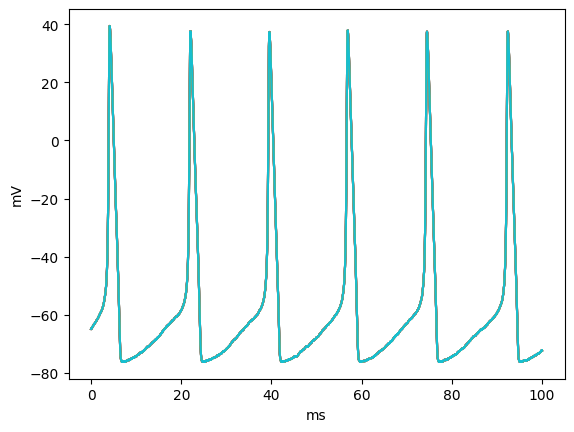

In [7]:
# Define the simulation times, from 0 to 100 ms with a time step of 'dt'
times = u.math.arange(0. * u.ms, 100. * u.ms, dt)

# Run the simulation using `brainstate.compile.for_loop`:
# - `run` function is called iteratively with each time step and random input current
# - Random input current between 1 and 10 uA/cm² is generated at each time step
# - `pbar` is used to show a progress bar during the simulation
vs = brainstate.compile.for_loop(run,
                                 times,  # Time steps as input
                                 brainstate.random.uniform(1., 10., times.shape) * u.uA / u.cm ** 2,  # Random input current (1 to 10 uA/cm²)
                                 pbar=brainstate.compile.ProgressBar(count=10))  # Show progress bar with 10 steps

# Plot the membrane potential over time
plt.plot(times, vs)
plt.show()  # Display the plot

## 脉冲神经元网络模型的仿真

神经科学研究的目的之一是要解开大脑编码信息的可能法则。作为一种编码法则，我们很自然指望神经元在相同刺激下产生相同的反应。但上世纪 80 至 90 年代，大量实验发现，同样的外部刺激重复呈现，大脑皮层中的神经元每次产生的脉冲序列都不同，且单次脉冲序列表现出极不规律的统计行为。范·弗雷斯维克（Van Vreeswijk）和海姆·索姆林斯基（Haim Sompolinsky）提出了**兴奋-抑制平衡网络（E-I balanced network）**。他们提出网络中应同时存在兴奋性神经元和抑制性神经元，且两种神经元的输入必须是平衡的、相互抵消的，此时神经元接收到输入的均值维持在一个很小的值，方差（波动）才足够显著，从而促使神经元无规律发放。除此以外，对网络还有以下要求：
+ 神经元之间的连接是随机且稀疏的，这使得不同神经元接收到的内部输入的统计相关性很小，宏观上表
现出更强的不规律性；
+ 统计上，一个神经元接收到的兴奋性输入和抑制性输入应该能大致抵消，即网络中传递的兴奋和抑制是平衡的；
+ 网络内部神经元之间的连接强度相对较强，这使得整个网络的活动不是被外部输入而是被网络内部突触
连接产生的电流主导，突触电流的随机起伏决定了神经元的无规律发放。

<center>
    <img src="./_static/snn-simulation1.png" alt="EI-balance" />
</center>

在这里我们对兴奋-抑制平衡网络模型进行仿真，作为脉冲神经元网络模型仿真的示例。

In [8]:
import brainunit as u
import brainstate as brainstate
import matplotlib.pyplot as plt

## 脉冲神经网络模型的定义

我们可以使用``brainstate``自定义脉冲神经网络模型。自定义脉冲神经网络模型需要继承模型基类``brainstate.nn.DynamicsGroup``。

1. 首先定义初始化类方法``__init__()``，接收模型参数,初始化模型。注意要先``super().__init__()``初始化基类。初始化模型主要包括初始化神经元和突触:
    - **初始化神经元**：网络中神经元可以选择``brainstate.nn``中已经实现好的各种神经元，也可以选用我们在**单神经元模型的定义**部分自定义的神经元。
    - **初始化突触**：这里使用了``brainstate.nn.AlignPostProj``，适用于align-post投射模型。align-post投射意味着突触变量和突触后神经元群的维度一致。align-post和align-pre模型的更新顺序不同，align-post投射模型更新顺序是动作电位 -> 突触通讯 -> 突触动力学 -> 输出；align-pre投射模型更新顺序是动作电位 -> 突触动力学 -> 突触通讯 -> 输出。它需要设置的几个参数分别是：
        - ``comm``：神经元群之间的连接是怎样的
        - ``syn``：使用哪种突触模型
        - ``out``：设置输出是基于电导还是基于电流的
        - ``post``：指出突触后神经元群。


2. 然后定义``update()``方法，接收每个时间步模型的input，更新模型当前状态。作为神经元群，神经元除了外界输入还要接收其它神经元的输入。因此在这个模型中，先计算神经元群接收神经元的输入，再计算接收外界输入。最后输出整个网络每个神经元的发放情况。

In [9]:
class EINet(brainstate.nn.DynamicsGroup):
    def __init__(self, n_exc, n_inh, prob, JE, JI):
        # Initialize the network with the following parameters:
        # - n_exc: number of excitatory neurons
        # - n_inh: number of inhibitory neurons
        # - prob: connection probability between neurons
        # - JE: synaptic weight for excitatory connections
        # - JI: synaptic weight for inhibitory connections
        super().__init__()

        self.n_exc = n_exc  # Number of excitatory neurons
        self.n_inh = n_inh  # Number of inhibitory neurons
        self.num = n_exc + n_inh  # Total number of neurons (excitatory + inhibitory)

        # Initialize the neurons as LIF (Leaky Integrate-and-Fire) neurons
        self.N = brainstate.nn.LIF(
            n_exc + n_inh,  # Total number of neurons
            V_rest=-52. * u.mV,  # Resting potential (mV)
            V_th=-50. * u.mV,  # Threshold potential for firing (mV)
            V_reset=-60. * u.mV,  # Reset potential after spike (mV)
            tau=10. * u.ms,  # Membrane time constant (ms)
            V_initializer=brainstate.nn.Normal(-60., 10., unit=u.mV),  # Initialize membrane potential with a normal distribution
            spk_reset='soft'  # Soft reset for spiking (reset without forcing a specific value)
        )

        # Synapse connections from excitatory neurons to all neurons
        self.E = brainstate.nn.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(n_exc, self.num, prob, JE),  # Fixed probability of synaptic connection with strength JE
            syn=brainstate.nn.Expon.desc(self.num, tau=2. * u.ms),  # Exponential decay of synaptic weight
            out=brainstate.nn.CUBA.desc(),  # CUBA (Conductance-based) synaptic model
            post=self.N,  # Target neurons for these excitatory synapses
        )

        # Synapse connections from inhibitory neurons to all neurons
        self.I = brainstate.nn.AlignPostProj(
            comm=brainstate.nn.EventFixedProb(n_inh, self.num, prob, JI),  # Fixed probability of synaptic connection with strength JI
            syn=brainstate.nn.Expon.desc(self.num, tau=2. * u.ms),  # Exponential decay of synaptic weight
            out=brainstate.nn.CUBA.desc(),  # CUBA (Conductance-based) synaptic model
            post=self.N,  # Target neurons for these inhibitory synapses
        )

    def update(self, inp):
        # Get the spike states of the neurons
        spks = self.N.get_spike() != 0.  # Non-zero spikes (spike detection)

        # Update the synaptic currents for excitatory and inhibitory neurons
        self.E(spks[:self.n_exc])  # Apply excitatory synaptic input based on the excitatory neuron spikes
        self.I(spks[self.n_exc:])  # Apply inhibitory synaptic input based on the inhibitory neuron spikes

        # Update the neurons with the provided input current (inp)
        self.N(inp)

        # Return the spike states of the neurons (whether each neuron spiked)
        return self.N.get_spike()

## 模型仿真实验运行

设置一些模型参数。在这个例子中，我们用连接强度的正负来设置神经元的兴奋抑制性。

In [10]:
# connectivity
num_exc = 500
num_inh = 500
prob = 0.1
# external current
Ib = 3. * u.mA
# excitatory and inhibitory synaptic weights
JE = 1 / u.math.sqrt(prob * num_exc) * u.mS
JI = -1 / u.math.sqrt(prob * num_inh) * u.mS

定义仿真实验中dt对应的时间。

实例化定义好的模型后，要先``bst.nn.init_all_states()``初始化这个实例。

In [11]:
# network
brainstate.environ.set(dt=0.1 * u.ms)
net = EINet(num_exc, num_inh, prob=prob, JE=JE, JI=JI)
brainstate.nn.init_all_states(net)

EINet(
  layers_tuple=(),
  layers_dict={},
  n_exc=500,
  n_inh=500,
  num=1000,
  N=LIF(
    _name=None,
    in_size=(1000,),
    out_size=(1000,),
    current_inputs={
      'AlignPostProj0': CUBA(
        _conductance=None,
        scale=volt
      )
    },
    _delta_inputs=None,
    before_updates={
      "(<class 'brainstate.nn.Expon'>, (1000,), {'tau': 2. * msecond}) // (<class 'brainstate.nn.CUBA'>, (), {})": _AlignPost(
        syn=Expon(
          _name=None,
          in_size=(1000,),
          out_size=(1000,),
          _current_inputs=None,
          _delta_inputs=None,
          _before_updates=None,
          _after_updates=None,
          tau=2. * msecond,
          g_initializer=ZeroInit(
            unit=msiemens
          ),
          g=HiddenState(
            value=ShapedArray(float32[1000]) * msiemens
          )
        ),
        out=CUBA(...)
      )
    },
    _after_updates=None,
    spk_reset=soft,
    spk_fun=ReluGrad(alpha=0.3, width=1.0),
    R=1. * ohm

实例化的网络模型使用``update()``方法输入每步的输入电流。

使用``bst.compile.for_loop()``迭代运行函数，进行一段时间的仿真，第一个参数是要迭代的函数，随后是此函数所需要的参数。可以选择绘制迭代进度条。

这样就完成了脉冲神经元网络模型的仿真。

In [12]:
# Simulation
# Define the time array from 0 to 1000 ms with a step size of dt
times = u.math.arange(0. * u.ms, 1000. * u.ms, brainstate.environ.get_dt())

# Run the simulation using `brainstate.compile.for_loop`, iterating over each time step
# The `lambda t: net.update(Ib)` applies the `update` method of the network `net`
# for each time step, with `Ib` as the input current at each time step.
spikes = brainstate.compile.for_loop(
    lambda t: net.update(Ib),  # Call net.update with input current Ib
    times,  # Time steps
    pbar=brainstate.compile.ProgressBar(10)  # Show a progress bar with 10 steps
)

  0%|          | 0/10000 [00:00<?, ?it/s]

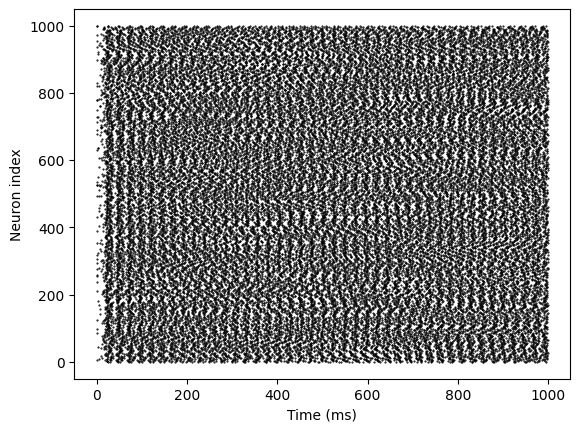

In [13]:
# visualization
times = times.to_decimal(u.ms)
t_indices, n_indices = u.math.where(spikes)
plt.plot(times[t_indices], n_indices, 'k.', markersize=1)
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.show()